# Phase linking with miaplpyApp #

[MiaplPy](https://github.com/insarlab/MiaplPy) is an open source python package of InSAR processing with Non Linear phase linking in full resolution. It reads a stack of coregistered SLCs and produces time series of surface deformation by jointly inverting for persistent and distributed scatterers (PS and DS). This Package works with [MintPy](https://github.com/insarlab/MintPy) and different correction steps after phase inversion are perfomed with MintPy. 
In this notebook, we describe different steps and available options in MiaplPy python package.

Details about the algorithms can be found at:
+ S. Mirzaee, F. Amelung, H. Fattahi, Non-linear phase linking using joined distributed And Persistent Scatterers. (in prep)


# general overview #

The time series analysis workflow in miaplpyApp consists of 8 steps which will be explained one by one through an example dataset.

###  Example data:
The example data we use here is a stack of Sentinel-1 images in descending track 142 acquired over Guagua Pichincha volcano, Ecuador ([Zenodo](https://zenodo.org/record/6539952/files/PichinchaSenDT142.zip); ~318M in size). It spans from 2016.04.19 to 2017.12.28 with 46 acquisitions in total. We use the stack Sentinel processor ([Fattahi et al., 2016](https://ieeexplore.ieee.org/document/7637021)) within ISCE ([Rosen et al., 2012](https://ieeexplore.ieee.org/document/6217174/authors#authors)) for coregistering the SAR stack.

## 0. Initial setup of the notebook ##

The cell below performs the intial setup of the notebook and **must be run every time the notebook (re)starts**. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mintpy.objects import ifgramStack
from mintpy.utils import plot as pp, utils as ut
from mintpy import view, plot_network

# define work directory
work_dir = os.path.expanduser('~/data/test')
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download example dataset
url = 'https://zenodo.org/record/6539952/files/PichinchaSenDT142.zip'
zip_file = os.path.basename(url)
proj_name = zip_file.split('.')[0]
if not os.path.isfile(zip_file):
    !wget {url}
else:
    print('{} exists, skip re-download.'.format(zip_file))

# uncompress example dataset
if not os.path.isdir(proj_name):
    print('uncompressing the zip file ...')
    !unzip -q {zip_file}

# go to project directory
proj_dir = os.path.join(work_dir, proj_name)
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

Go to work directory: /Users/Sara/data/test
PichinchaSenDT142.zip exists, skip re-download.
Go to project directory: /Users/Sara/data/test/PichinchaSenDT142


## 1. Setting up template file ##

The configuration parameters to miaplpyApp.py are controlled through three template files. At least one template is required to run miaplpyApp.py.    

+ `default template`: [miaplpyApp.cfg](https://github.com/insarlab/MiaplPy/blob/main/miaplpy/defaults/miaplpyApp.cfg). It contains all MiaplPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [miaplpyApp_auto.cfg](https://github.com/insarlab/MiaplPy/blob/main/miaplpy/defaults/miaplpyApp_auto.cfg)). This file is copied over to the current working directory and read every time miaplpyApp.py runs.


+ `default template`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). It contains all MintPy configuration parameters, grouped by steps, with default _auto_ values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.


+ `custom template` (optional but recommended): PichinchaSenDT142.template in the example dataset. It contains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the two default templates; if custom template is input, miaplpyApp.py will update the default miaplpyApp.cfg and smallbaselineApp.cfg files accordingly.  



### Using Docker/Singularity ###

There is `miaplpy.textCmd` options at the beginning of default `miaplpyApp.cfg` template file which you may want to set them if you need to run a specific command before everything. For example if you use docker, you need to run commands like this:
```
docker run {your command}
docker run miaplpyApp.py -h
```
Then you should set:
```
miaplpy.textCmd   =  docker run
```
### Parallel processing ###

If you want to run tasks in parallel, then you can set the number of workers/cores per node with `miaplpy.compute.numCores` option. The default is set to 4 for a personal computer with 4 CPUs.

### Custom template example ###

The path of all input files (`miaplpy.load.*`), subset area (`miaplpy.subset.*`) and the reference point (`mintpy.reference.*`) are always recommended. Below are from PichinchaSenDT142.template file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_slc_geometry.py -H to check more details and example inputs.

miaplpy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isceTops
miaplpy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
miaplpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
miaplpy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:        
miaplpy.load.slcFile        = ../merged/SLC/*/*.slc.full  #[path2slc_file]
##---------for ISCE only:
miaplpy.load.metaFile       = ../reference/IW*.xml
miaplpy.load.baselineDir    = ../baselines
##---------geometry datasets:
miaplpy.load.demFile          = ../merged/geom_reference/hgt.rdr.full
miaplpy.load.lookupYFile      = ../merged/geom_reference/lat.rdr.full
miaplpy.load.lookupXFile      = ../merged/geom_reference/lon.rdr.full
miaplpy.load.incAngleFile     = ../merged/geom_reference/los.rdr.full
miaplpy.load.azAngleFile      = ../merged/geom_reference/los.rdr.full
miaplpy.load.shadowMaskFile   = ../merged/geom_reference/shadowMask.rdr.full
miaplpy.load.waterMaskFile    = None
##---------interferogram datasets:
miaplpy.load.unwFile        = ./inverted/interferograms_single_reference/*/*fine*.unw
miaplpy.load.corFile        = ./inverted/interferograms_single_reference/*/*fine*.cor
miaplpy.load.connCompFile   = ./inverted/interferograms_single_reference/*/*.unw.conncomp

##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
miaplpy.subset.lalo         = -0.199:-0.142,-78.612:-78.578

# MiaplPy options
miaplpy.compute.numCores   = 8
miaplpy.interferograms.type = single_reference

## Mintpy options
mintpy.compute.cluster     = local  # if dask is not available, set this option to no
mintpy.compute.numWorker   = 8


```
    
Run **load_slc_geometry.py -H** for example input file paths for ISCE, GAMMA and ROI_PAC.  

There are two sets of options for **MiaplPy (miaplpyApp.cfg)** starting with `miaplpy.*` and for **MintPy (smallbaselineApp.cfg)** starting with `mintpy.*`

Run **miaplpyApp.py -H** for a complete list of options you can use and add to your custom template file.


## 2. miaplpyApp.py processing steps ##

The miaplpyApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. 
If you work on HPC, you can create jobs for each step and run them one by one.
More detailed usage can be found in help. 

In [5]:
!miaplpyApp.py --help

usage: miaplpyApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--walltime WALL_TIME] [--queue QUEUE] [--jobfiles] [--runfiles] [--tmp] [--start STEP]
                     [--end STEP] [--dostep STEP]
                     [customTemplateFile]

Routine Time Series Analysis for MiaplPy

positional arguments:
  customTemplateFile    Custom template with option settings.
                        ignored if the default miaplpyApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        Work directory, (default: None).
  -g                    Generate default template (if it does not exist) and exit.
  -H                    Print the default template file and exit.
  -v, --version         Print software version and exit
  --walltime WALL_TIME  walltime for submitting the script as a job
  --queue QUEUE         Queue name
  --jobfiles            Do not run the tasks, only write job files
  --runfiles       

### 2.1. Create processing steps run files ###

Running `miaplpyApp.py` with `--runfiles` will create all steps as separate runfiles and you can then run them one by one.

```
miaplpyApp.py PichinchaSenDT142.txt --runfiles --dir ./miaplpy
```

#### Creating jobs on HPC ####
If you are on HPC, you can create jobs for each run file. If [MinSAR](https://github.com/geodesymiami/rsmas_insar) is installed, you may create jobs automatically by running following command and then submit them in order

```
miaplpyApp.py PichinchaSenDT142.txt --jobfiles --dir ./miaplpy
```

*We will not run it here since we are not on HPC for this tutorial*


In [7]:
!miaplpyApp.py PichinchaSenDT142.txt --runfiles --dir ./miaplpy

--------------------------------------------------

_________________________________________________      

  /##      /## /##                     / ## /#######
 | ###    /###|__/|                    | ##| ##__  ##
 | ####  /#### /##|/ ##### /##         | ##| ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ### /####### | ##| #######/| ##  | ##
 | ##  ###| ##| ##| ##__  ###| ##__  ##| ##| ##      | ##  | ##
 | ##\  # | ##| ##| ##   \###| ##   \##| ##| ##      | ##  | ##
 | ## \/  | ##| ##|  ##### ##| #######/| ##| ##      |  #######
 |__/     |__/|__/| \____/|_/| ##____/ |__/|__/       \____  ##
                             | ##                     /##  | ## 
                             | ##                    |  ######/         
                             |__/                     \______/
 Miami Non-Linear Phase Linking software in Python   
          MiaplPy 0.2.0, 2021-09-14
_________________________________________________

--RUN-at-2022-05-11 21:59:07.803756--
Current directory: /

In [10]:
!ls -l miaplpy

total 88
-rw-rw-r--  1 Sara  staff    244 May 11 21:53 conf.full
-rw-rw-r--  1 Sara  staff  21438 May 11 21:59 custom_smallbaselineApp.cfg
drwxrwxr-x  8 Sara  staff    256 May 11 21:53 inputs
drwxrwxr-x  3 Sara  staff     96 May 11 21:53 inverted
-rw-rw-r--  1 Sara  staff    243 May 11 21:59 log
-rw-rw-r--  1 Sara  staff   7923 May 11 21:59 miaplpyApp.cfg
drwxrwxr-x  6 Sara  staff    192 May 11 21:59 network_single_reference
-rw-rw-r--  1 Sara  staff    274 May 11 21:59 run_files_list


In [11]:
!ls -l miaplpy/network_single_reference/run_files

total 144
-rw-rw-r--  1 Sara  staff    229 May 11 21:59 run_01_miaplpy_load_data
-rw-rw-r--  1 Sara  staff   1280 May 11 21:59 run_02_miaplpy_phase_linking
-rw-rw-r--  1 Sara  staff    224 May 11 21:59 run_03_miaplpy_concatenate_patches
-rw-rw-r--  1 Sara  staff  15354 May 11 21:59 run_04_miaplpy_generate_ifgram
-rw-rw-r--  1 Sara  staff  27351 May 11 21:59 run_05_miaplpy_unwrap_ifgram
-rw-rw-r--  1 Sara  staff    475 May 11 21:59 run_06_miaplpy_load_ifgram
-rw-rw-r--  1 Sara  staff    212 May 11 21:59 run_07_mintpy_ifgram_correction
-rw-rw-r--  1 Sara  staff    421 May 11 21:59 run_08_miaplpy_invert_network
-rw-rw-r--  1 Sara  staff    181 May 11 21:59 run_09_mintpy_timeseries_correction


### 2.2 Load SLC and geometry stack ###

This step prepares the required metadata (using prep_isce.py) and load all data files and their metadata into HDF5 files in the **./inputs** folder, including:

```cfg
./inputs/slcStack.h5
./inputs/geometryRadar.h5  #for dataset in radar coordinates
./inputs/geometryGeo.h5    #for dataset in geo coordinates or GAMMA dataset, which has lookup table in geo-coordinates
```

The corresponding template options are:

```cfg
########## 1. load data given the area of interest
## auto - automatic path pattern for Univ of Miami file structure
## crop_image.py -h to check more details and example inputs.
## directories are to read from and the subsets will be saved under miaplpy directory
## compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]

miaplpy.load.processor      = auto  #[isce,snap,gamma,roipac], auto for isceTops
miaplpy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
miaplpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
miaplpy.load.autoPath       = auto    # [yes, no] auto for no
##---------Coregistered SLC images:
miaplpy.load.slcFile        = auto  #[path2slc_file]
miaplpy.load.startDate      = auto  #auto for first date
miaplpy.load.endDate        = auto  #auto for last date
##---------for ISCE only:
miaplpy.load.metaFile       = auto  #[path2metadata_file], i.e.: ./reference/IW1.xml, ./referenceShelve/data.dat
miaplpy.load.baselineDir    = auto  #[path2baseline_dir], i.e.: ./baselines
##---------geometry datasets:
miaplpy.load.demFile        = auto  #[path2hgt_file]
miaplpy.load.lookupYFile    = auto  #[path2lat_file], not required for geocoded data
miaplpy.load.lookupXFile    = auto  #[path2lon_file], not required for geocoded data
miaplpy.load.incAngleFile   = auto  #[path2los_file], optional
miaplpy.load.azAngleFile    = auto  #[path2los_file], optional
miaplpy.load.shadowMaskFile = auto  #[path2shadow_file], optional
miaplpy.load.waterMaskFile  = auto  #[path2water_mask_file], optional
miaplpy.load.bperpFile      = auto  #[path2bperp_file], optional

##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
miaplpy.subset.yx           = auto    #[y0:y1,x0:x1 / no], auto for no
miaplpy.subset.lalo         = auto    #[S:N,W:E / no], auto for no
```

You can either run:
```
miaplpyApp.py PichinchaSenDT142.txt --dostep load_data --dir ./miaplpy
```
or run the commands in `run_01_miaplpy_load_data`


In [12]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep load_data --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:02:48.910700--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_data']
Remaining steps: ['phase_linking', 'concatenate_patches', 'generate_ifgram', 'unwrap_ifgram', 'load_ifgram', 'ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:220248 * miaplpyApp.py PichinchaSenDT142.txt --dostep load_data --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.com

In [13]:
!ls -l miaplpy/inputs

total 739856
-rw-r--r--   1 Sara  staff       1875 Apr 21 14:46 PichinchaSenDT142.txt
drwxr-xr-x  53 Sara  staff       1696 Feb 10 12:56 baselines
-rw-rw-r--   1 Sara  staff        413 May 11 22:02 date_list.txt
-rw-rw-r--   1 Sara  staff   12206169 May 11 22:02 geometryRadar.h5
-rw-rw-r--   1 Sara  staff       7923 May 11 21:59 miaplpyApp.cfg
drwxr-xr-x   4 Sara  staff        128 Feb 10 12:56 reference
-rw-rw-r--   1 Sara  staff  354537760 May 11 22:02 slcStack.h5
-rw-rw-r--   1 Sara  staff      21438 May 11 22:02 smallbaselineApp.cfg


In [14]:
!info.py miaplpy/inputs/slcStack.h5

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inputs/slcStack.h5
file type: timeseries
coordinates : RADAR

******************** Date Stat Info *************************
Start Date: 20160419
End   Date: 20171228
Number of dates  : 46
STD of datetimes : 0.51 years

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                    1
  ANTENNA_SIDE              -1
  AZIMUTH_PIXEL_SIZE        15.61631188914008
  BANDS                     1
  CENTER_INCIDENCE_ANGLE    46.153805
  CENTER_LINE_UTC           39141.0
  DATA_TYPE                 complex64
  DATE                      20161209
  EARTH_RADIUS              6337298.410627297
  FILE_LENGTH               530
  FILE_PATH                 /Users/Sara/data/test/PichinchaSenDT142/merged/SLC/20161209/20161209.slc.full
  FILE_TYPE                 timeseries
  HEADING                   -167.96890986886464
  HEIGHT          

In [16]:
!info.py ./miaplpy/inputs/geometryRadar.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inputs/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                    1
  ANTENNA_SIDE              -1
  AZIMUTH_PIXEL_SIZE        15.61631188914008
  BANDS                     1
  CENTER_INCIDENCE_ANGLE    46.153805
  CENTER_LINE_UTC           39141.0
  DATA_TYPE                 complex64
  DATE                      20161209
  EARTH_RADIUS              6337298.410627297
  FILE_LENGTH               530
  FILE_PATH                 /Users/Sara/data/test/PichinchaSenDT142/merged/SLC/20161209/20161209.slc.full
  FILE_TYPE                 geometry
  HEADING                   -167.96890986886464
  HEIGHT                    698882.4836057822
  INTERLEAVE                BSQ
  LAT_REF1                  -0.14213333
  LAT_REF2                  -0.13301475
  LAT_REF3      

run view.py in MintPy version v1.3.3, date 2022-04-14
input file is geometry file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inputs/geometryRadar.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file geometryRadar.h5: 7
datasets to exclude (0):
[]
datasets to display (7):
['azimuthAngle', 'height', 'incidenceAngle', 'latitude', 'longitude', 'shadowMask', 'slantRangeDistance']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: jet
DESCENDING orbit -> flip left-right
figure title: geometryRadar
figure size : [15.00, 8.00]
dataset number: 7
row     number: 4
column  number: 2
figure  number: 1
----------------------------------------
Figure 1 - geometryRadar.png
reading data as a list of 2D matrices ...
[==================================================] slantRangeDistance     0s  0

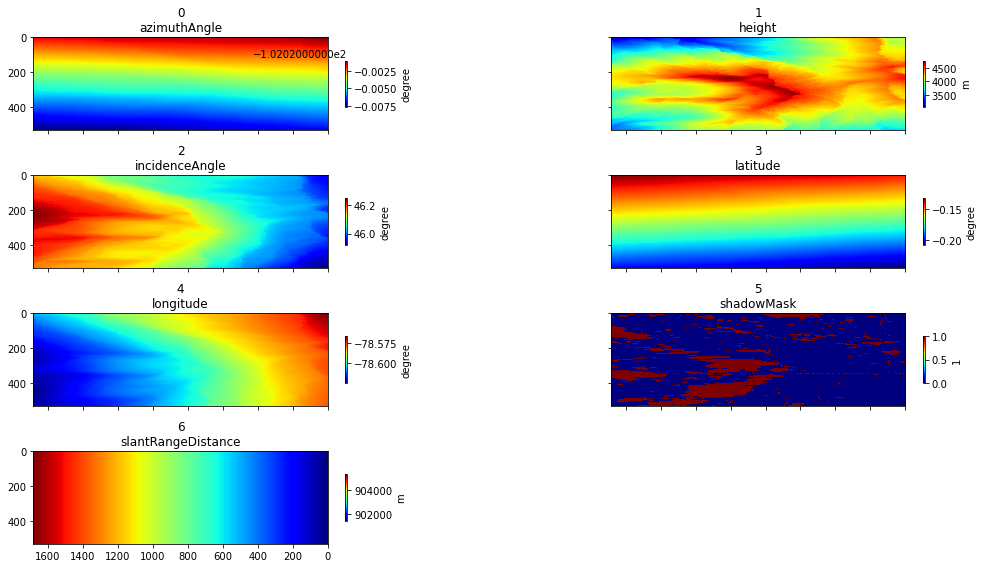

In [17]:
view.main('./miaplpy/inputs/geometryRadar.h5'.split())

### 2.2 Phase inversion ###

This step runs the phase linking using wrapped phase series. following are the options used for this step. Phase linking methods supported by MiaplPy are **EVD** ([Fornaro et al., 2015](https://ieeexplore.ieee.org/document/6912985), **EMI** ([Ansari et al., 2018](https://ieeexplore.ieee.org/document/8365087)) and **PTA** ([Ferretti et al., 2011](https://ieeexplore.ieee.org/abstract/document/5765671)). All of them can be run in sequential mode **(sequential_EVD, sequential_EMI and sequential_PTA)** ([Ansari et al., 2017](https://ieeexplore.ieee.org/document/8024151)). 
MiaplPy also supports **SBW** [Ansari et al., 2017] and you can choose a bandwidth (number of connections) by setting `miaplpy.inversion.sbw_connNum ` option in template.

For sequential mode, you can set the number of images as ministack size by `miaplpy.inversion.ministackSize`. Range and azimuth window are the size of searching window to find statistical homogeneous pixels (SHPs). Shp test is the statistical test to find SHPs and three tests are supported by MiaplPy including **KS** ([Stephens, 1970](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1970.tb00821.x)), **AD** ([Scholz & Stephens, 1987](https://www.tandfonline.com/doi/abs/10.1080/01621459.1987.10478517)) and **ttest** ([Derrick et al., 2017](https://www.tqmp.org/RegularArticles/vol13-2/p120/)).

This step supports parallel processing by dividing the subset area into patches of size `n by n`, for example the default size is 200 and the data will be divided into patches of size `200 by 200`. You can set the number of parallel jobs (no more than available CPUs) using `miaplpy.multiprocessing.numCores` and the patch size by `miaplpy.inversion.patchSize `. 

Depending on the number of parallel jobs, number of images, the processing method and the subset area (number of patches), the processing time varies. For one patch of `200*200` pixels and 46 images, processing time is 400 seconds (6 min) with a 2.8 GHz processor. 


```cfg
########## 2. parallel job setting
miaplpy.multiprocessing.numCores           = auto    # auto for 4

########## 4. Divide the area into patches and do phase inversion
## window sizes are used in step 2, 3,
miaplpy.inversion.patchSize                = auto   # patch size (n*n) to divide the image for parallel processing, auto for 200
miaplpy.inversion.ministackSize            = auto   # number of images in each ministack, auto for 10
miaplpy.inversion.rangeWindow              = auto   # range window size for searching SHPs, auto for 15
miaplpy.inversion.azimuthWindow            = auto   # azimuth window size for searching SHPs, auto for 15
miaplpy.inversion.shpTest                  = auto   # [ks, ad, ttest] auto for ks: kolmogorov-smirnov test
miaplpy.inversion.phaseLinkingMethod       = auto   # [EVD, EMI, PTA, sequential_EVD, sequential_EMI, sequential_PTA, SBW], auto for sequential_EMI
miaplpy.inversion.sbw_connNum              = auto   # auto for 10, number of consecutive interferograms
miaplpy.inversion.PsNumShp                 = auto   # auto for 10, number of shps for ps candidates
miaplpy.inversion.mask                     = auto   # mask file for phase inversion, auto for None

```


Either run:
```
miaplpyApp.py PichinchaSenDT142.txt --dostep phase_inversion --dir ./miaplpy
```
or run the commands in run_02_miaplpy_phase_linking


In [19]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep phase_linking --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:10:29.661983--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['phase_linking']
Remaining steps: ['concatenate_patches', 'generate_ifgram', 'unwrap_ifgram', 'load_ifgram', 'ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:221029 * miaplpyApp.py PichinchaSenDT142.txt --dostep phase_linking --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.clus

Reading SLC data from /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inputs/slcStack.h5 and inverting patches in parallel ...
[==================================================] 11050/11050 pixels, patch 26    Phase inversion of PATCH_0026 is Completed in 00 mins 31 secs

[==================================================] 26000/26000 pixels, patch 25    Phase inversion of PATCH_0025 is Completed in 01 mins 31 secs

[==================================================] 26000/26000 pixels, patch 24  110s /     2s    Phase inversion of PATCH_0024 is Completed in 01 mins 35 secs

Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy

###############################################################
Normal end of Non-Linear time series processing workflow!
##############################################################
Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy

################################################
   Normal end of miaplpyApp processing

### 2.3 Concatenate patches ###

After phase linking of all patches, this step would concatenate them

Either run:
```
miaplpyApp.py PichinchaSenDT142.txt --dostep concatenate_patches --dir ./miaplpy
```
or run the commands in run_03_miaplpy_concatenate_patches


In [20]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep concatenate_patches --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:29:45.742149--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['concatenate_patches']
Remaining steps: ['generate_ifgram', 'unwrap_ifgram', 'load_ifgram', 'ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:222945 * miaplpyApp.py PichinchaSenDT142.txt --dostep concatenate_patches --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto -

In [21]:
!ls ./miaplpy/inverted

PATCHES                         interferograms_single_reference tempCoh_average.xml             top_eigenvalues
amp_dipersion_index             phase_series.h5                 tempCoh_full                    top_eigenvalues.vrt
amp_dipersion_index.vrt         tempCoh_average                 tempCoh_full.vrt                top_eigenvalues.xml
amp_dipersion_index.xml         tempCoh_average.vrt             tempCoh_full.xml


In [22]:
!ls ./miaplpy

conf.full                   inputs                      log                         miaplpyApp.cfg              run_files_list
custom_smallbaselineApp.cfg inverted                    maskPS.h5                   network_single_reference


### Temporal Coherence ###

So far we have inverted the wrapped phase series with sequential_EMI phase linking method and we have the single reference interferograms saved in HDF5 format. The interferograms then need to be unwrapped and converted to displacement time series.

+ There are two temporal coherence (also known as PTA coherence) calculated. 
`tempCoh_average` which referes to the average of quality values estimated in each mini stack and `tempCoh_full` which refers to the long term quality calculated from the final phase linked vector. As it is shown below, the full version is better to filter noisy pixels while the average has higher values which is more useful in unwrapping. The user may choose one of them based on application.

+ A by product of inversion is PS mask `maskPS.h5` for those who are interested in PS pixels only specially in urban areas.

view.py ./miaplpy/inverted/tempCoh_full -c gray --notick --noaxis --noverbose


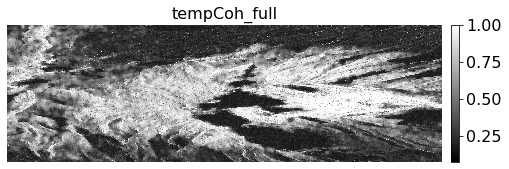

view.py ./miaplpy/inverted/tempCoh_average -c gray --notick --noaxis --noverbose


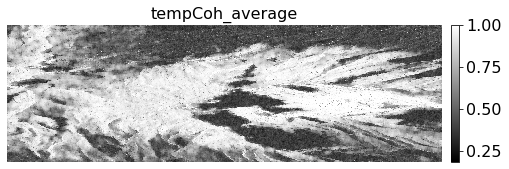

view.py ./miaplpy/maskPS.h5 --notick --noaxis --noverbose


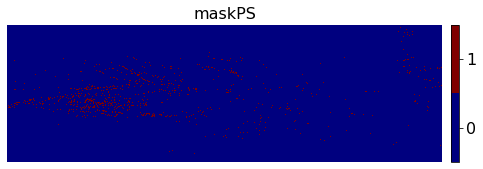

In [24]:
view.main('./miaplpy/inverted/tempCoh_full -c gray --notick --noaxis --noverbose'.split())
view.main('./miaplpy/inverted/tempCoh_average -c gray --notick --noaxis --noverbose'.split())
view.main('./miaplpy/maskPS.h5 --notick --noaxis --noverbose'.split())

run view.py in MintPy version v1.3.3, date 2022-04-14
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/phase_series.h5 in float32 format
file size in y/x: (530, 1685)
input dataset: "['phase']"
num of datasets in file phase_series.h5: 95
datasets to exclude (0):
[]
datasets to display (46):
['phase-1', 'phase-2', 'phase-3', 'phase-4', 'phase-5', 'phase-6', 'phase-7', 'phase-8', 'phase-9', 'phase-10', 'phase-11', 'phase-12', 'phase-13', 'phase-14', 'phase-15', 'phase-16', 'phase-17', 'phase-18', 'phase-19', 'phase-20', 'phase-21', 'phase-22', 'phase-23', 'phase-24', 'phase-25', 'phase-26', 'phase-27', 'phase-28', 'phase-29', 'phase-30', 'phase-31', 'phase-32', 'phase-33', 'phase-34', 'phase-35', 'phase-36', 'phase-37', 'phase-38', 'phase-39', 'phase-40', 'phase-41', 'phase-42', 'phase-43', 'phase-44', 'phase-45', 'phase-46']
data   coverage in y/x: (0, 0, 1685, 530)
subset coverage in y/x: (0, 0, 1685, 530)
data   coverage in lat/lon: None
subset c

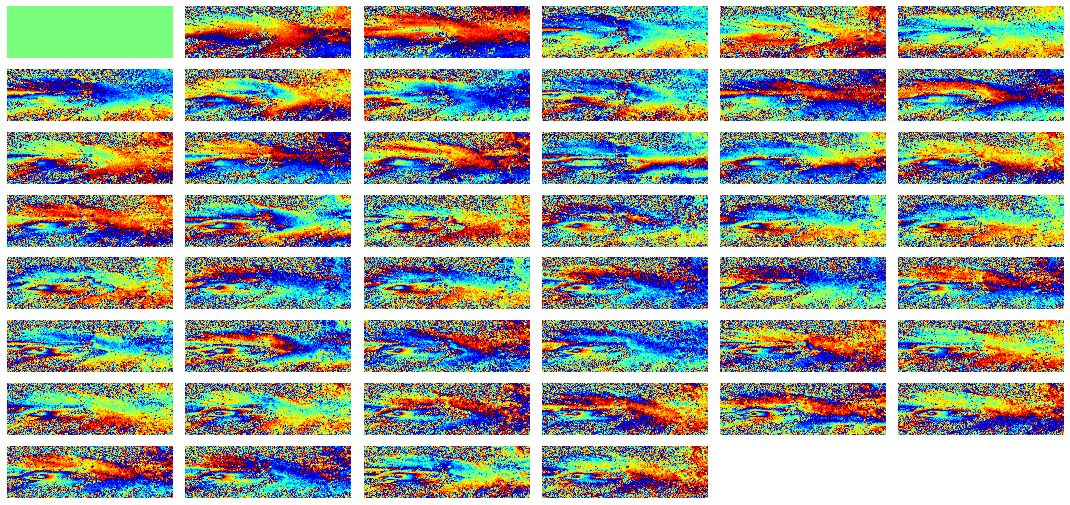

In [25]:
view.main('./miaplpy/inverted/phase_series.h5 phase --noaxis --nowhitespace'.split())

### 2.4 Select pairs to unwrap (generate_ifgram) ###

Since you are working in full resolution and for long temporal baselines, you may have low spatial coherence making unwrapping difficult. So in MiaplPy, you can select a network of minimum interferograms to unwrap and then convert phase to range changes.

For that, there are four options for which pairs to unwrap (following options in template). We use the single reference pairs for this example.
The filter strength has been set to 0 by default but you may do additional filtering at this step.

```cfg
########## 4. Select the network and generate interferograms
## Different pairs of interferograms can be choosed for unwrapping.
## Following is a short description of each type 
## 1. mini_stacks: It unwraps single reference interferograms in each ministack which is formed from images of each year
## 2. single_reference: It unwraps the single reference interferograms of the whole stack using referenceDate. 
## 3. delaunay: delaunay triangles with temporal and spatial baseline threshold. 
## 4. sequential: sequential interferograms
## You may also unwrap certain combination of pairs by giving them in a text file as miaplpy.interferograms.list
miaplpy.interferograms.networkType             = auto     # [mini_stacks, single_reference, sequential, delaunay] default: single_reference
miaplpy.interferograms.list                    = auto     # auto for None, list of interferograms to unwrap in a text file
miaplpy.interferograms.referenceDate           = auto     # auto for the middle image
miaplpy.interferograms.filterStrength          = auto     # [0-1], interferogram smoothing factor, auto for 0
miaplpy.interferograms.ministackRefMonth       = auto     # The month of the year that coherence is high to choose reference from, default: 6
miaplpy.interferograms.connNum                 = auto     # Number of connections in sequential interferograms, auto for 3
miaplpy.interferograms.delaunayBaselineRatio   = auto     # [1, 4, 9] Ratio between perpendiclar and temporal baselines, auto for 1
miaplpy.interferograms.delaunayTempThresh      = auto     # [days] temporal threshold for delaunay triangles, auto for 120
miaplpy.interferograms.delaunayPerpThresh      = auto     # [meters] Perp baseline threshold for delaunay triangles, auto for 200
miaplpy.interferograms.oneYear                 = auto     # [yes, no ] Add one year interferograms, auto for no
```

**The network for single reference pairs:**

<p align="left">
  <img width="600" src="figures/network_single_reference.png">
</p>     

**Annual ministack pairs:**

<p align="left">
  <img width="600" src="figures/network_annual_ministacks.png">
</p>     


**Delaunay triangle pairs:**

<p align="left">
  <img width="600" src="figures/network_delaunay_4.png">
</p>     

**sequential pairs:**

<p align="left">
  <img width="600" src="figures/network_sequential_3.png">
</p> 

In [26]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep generate_ifgram --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:50:51.844506--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['generate_ifgram']
Remaining steps: ['unwrap_ifgram', 'load_ifgram', 'ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:225051 * miaplpyApp.py PichinchaSenDT142.txt --dostep generate_ifgram --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request fo

line:   512
number of lines written to file: 544
Rescaling magnitude

number of lines written to file: 544

number of lines written to file: 544
line:     2Rescaling magnitude
line:     3Rescaling magnitude
line:    27
number of lines written to file: 544
line:    30Rescaling magnitude
line:    32
number of lines written to file: 544
line:    35Rescaling magnitude
line:    28
number of lines written to file: 544
line:    30
number of lines written to file: 544
line:    30Rescaling magnitude
line:    32Rescaling magnitude
line:    58
number of lines written to file: 544
line:    98Rescaling magnitude
line:   476GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/fine.int.vrt
line:   505API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/filt_fine.int
line:   448GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_refe


 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

*** Normal Completion  ***

GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request fo

line:    32
number of lines written to file: 544
Rescaling magnitude
line:     3GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161016/fine.int.vrt
line:    14GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161022/fine.int.vrt
line:    16API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161016/filt_fine.int
line:    182022-05-11 22:51:01,956 - isce.mroipac.filter - DEBUG - width: 1685
2022-05-11 22:51:01,956 - isce.mroipac.filter - DEBUG - length: 530
2022-05-11 22:51:01,956 - isce.mroipac.filter - DEBUG - input: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161016/fine.int
2022-05-11 22:51:01,956 - isce.mroipac.filter - DEBUG - output: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_2016

line:   520API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161115/filt_fine.cor
line:   522
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:   529
 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161022/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161022/filt_fine.int

 azimuth buffer size: 

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request fo

API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170303/fine.int
line:    96GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170219/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170219/filt_fine.int
2022-05-11 22:51:05,607 - isce.mroipac.filter - DEBUG - width: 1685
2022-05-11 22:51:05,608 - isce.mroipac.filter - DEBUG - length: 530
2022-05-11 22:51:05,609 - isce.mroipac.filter - DEBUG - input: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170219/fine.int
line:   1602022-05-11 22:51:05,609 - isce.mroipac.filter - DEBUG - output: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_

line:   279API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170102/filt_fine.cor
line:   291
 << PS filtering >>

line:   318
 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
line:   334 wisdomFile, length =            0
line:   148
 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1
line:   464
line:   459 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for

line:   310GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.int
line:   314GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170303/fine.int.vrt
line:   315API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170303/filt_fine.int
line:   353GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170219/filt_fine.int.vrt
line:   381API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170219/filt_fine.cor
line:   395
 << PS filtering >>

line:   396
 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lin

20220511:225108 * generate_ifgram.py --reference 20170408 --secondary 20170514 --output_dir /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170514 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/phase_series.h5
/Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170514
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the li

line:   288GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/fine.int.vrt
line:   384API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.int
2022-05-11 22:51:09,436 - isce.mroipac.filter - DEBUG - width: 1685
2022-05-11 22:51:09,436 - isce.mroipac.filter - DEBUG - length: 530
2022-05-11 22:51:09,436 - isce.mroipac.filter - DEBUG - input: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/fine.int
2022-05-11 22:51:09,437 - isce.mroipac.filter - DEBUG - output: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.int
2022-05-11 22:51:09,437 - isce.mroipac.filter - DEBUG - filter strength: 0.0
2022-05-11 22:51:09,437 - isce.mroipac.filter - INFO - Filtering interferogram
array width, height, offset:  1685   530     0
line

line:   522GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.int.vrt
line:   529GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170526/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170607/filt_fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.cor

 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patc

20220511:225112 * generate_ifgram.py --reference 20170408 --secondary 20170830 --output_dir /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170830 --azimuth_looks 1 --range_looks 1 --filter_strength 0 --stack_prefix tops --stack /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/phase_series.h5
/Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170830
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the li

line:     0API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170806/filt_fine.int
2022-05-11 22:51:13,312 - isce.mroipac.filter - DEBUG - width: 1685
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171005/fine.int.vrt
2022-05-11 22:51:13,312 - isce.mroipac.filter - DEBUG - length: 530
2022-05-11 22:51:13,312 - isce.mroipac.filter - DEBUG - input: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170806/fine.int
2022-05-11 22:51:13,312 - isce.mroipac.filter - DEBUG - output: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170806/filt_fine.int
2022-05-11 22:51:13,313 - isce.mroipac.filter - DEBUG - filter strength: 0.0
2022-05-11 22:51:13,313 - isce.mroipac.filter - INFO - Filtering interferogram
array width, height, offset:  1685   530     0
line:     0API 


 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  530
 starting output line:    1   ending output line:  530

 azimuth buffe

API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171216/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171228/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171204/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171110/fine.int
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171122/fine.int
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171110/fine.int
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171110/fine.int.vrt
API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferog

line:   510GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.int.vrt
line:   529API open (WR): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171122/filt_fine.cor
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171228/fine.int.vrt
API close:  /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171228/filt_fine.int

 << PS filtering >>


 interferogram width:  1685  number of lines/patch:  3700
 start line:        1  number of lines:     530
 start sample:      1  end sample:         1685
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lin

In [27]:
!ls ./miaplpy/inverted/interferograms_single_reference

20170408_20160419 20170408_20160724 20170408_20161016 20170408_20170126 20170408_20170502 20170408_20170713 20170408_20170923 20170408_20171204
20170408_20160501 20170408_20160805 20170408_20161022 20170408_20170219 20170408_20170514 20170408_20170725 20170408_20171005 20170408_20171216
20170408_20160513 20170408_20160817 20170408_20161109 20170408_20170303 20170408_20170526 20170408_20170806 20170408_20171017 20170408_20171228
20170408_20160525 20170408_20160829 20170408_20161115 20170408_20170315 20170408_20170607 20170408_20170818 20170408_20171029
20170408_20160606 20170408_20160910 20170408_20161209 20170408_20170327 20170408_20170619 20170408_20170830 20170408_20171110
20170408_20160630 20170408_20160922 20170408_20170102 20170408_20170420 20170408_20170701 20170408_20170911 20170408_20171122


### 2.5 Unwrap interferograms ###

For this step you may use your own unwrapping software. MiaplPy uses [SNAPHU](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/) and you can set the following parameters for unwrapping. If you have a mask in HDF5 format like `waterMask.h5`, you can use it by `miaplpy.unwrap.mask`

```cfg
miaplpy.unwrap.two-stage                  = auto     # [yes, no], auto for yes, Do two stage unwrapping
miaplpy.unwrap.removeFilter               = auto     # [yes, no], auto for yes, remove filter after unwrap
miaplpy.unwrap.snaphu.maxDiscontinuity    = auto     # (snaphu parameter) max phase discontinuity in cycle, auto for 1.2
miaplpy.unwrap.snaphu.initMethod          = auto     # [MCF, MST] auto for MCF
miaplpy.unwrap.snaphu.tileNumPixels       = auto     # number of pixels in a tile, auto for 10000000
miaplpy.unwrap.mask                       = auto     # auto for None

```

Furthermore, if you want to set mote [parameters](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/snaphu.conf.full) from snaphu, you can add them in `conf.full` in your miaplpy directory (PichinchaSenDT142/miaplpy/conf.full). MiaplPy will unwrap in tile mode if your subset area is large. Following you will find the parameters set by default:


In [28]:
!cat ./miaplpy/conf.full

INITMETHOD	MCF
INITONLY    FALSE
INFILEFORMAT   COMPLEX_DATA
OUTFILEFORMAT	ALT_LINE_DATA
CORRFILEFORMAT	FLOAT_DATA
MINCONNCOMPFRAC 	0.01
SINGLETILEREOPTIMIZE   FALSE
STATCOSTMODE  DEFO
RMTMPTILE 	   TRUE
MAXNCOMPS       100
CONNCOMPTHRESH  300


In [29]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep unwrap_ifgram --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:52:46.092059--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['unwrap_ifgram']
Remaining steps: ['load_ifgram', 'ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:225246 * miaplpyApp.py PichinchaSenDT142.txt --dostep unwrap_ifgram --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute.numWorker: auto --> 

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160630/filt_fine.unw.conncomp.vrt
Time spent: 0.6685149312019348 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160724/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/201704

snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160817/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160817/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160817/filt_fine.unw
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160922/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160922/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160922/filt_fine.unw
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160910/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20160910/

20220511:225410 * unwrap_ifgram.py --ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/tempCoh_average --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.unw --max_discontinuity 1.2 --init_method MCF --length 530 --width 1685 --height 698882.4836057822 --num_tiles 1 --earth_radius 6337298.410627297 --wavelength 0.05546576 -m /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/mask_unwrap
20220511:225410 * unwrap_ifgram.py --ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/tempCoh_average --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fin

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170126/filt_fine.unw.conncomp.vrt
Time spent: 0.6054421663284302 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20161209/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/201704

b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.conncomp.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170619/filt_fine.unw.conncomp.vrt
Time spent: 0.5612964351971944 m
b''
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.unw.vrt
GDAL close: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170526/filt_fine.unw.vrt
GDAL open (R): /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/201704

snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170830/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170830/filt_fine.unw
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171005/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171005/filt_fine.int 1685 -o /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171005/filt_fine.unw
snaphu -f /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170806/config_all -d /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20170806/

20220511:225608 * unwrap_ifgram.py --ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171110/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/tempCoh_average --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171110/filt_fine.unw --max_discontinuity 1.2 --init_method MCF --length 530 --width 1685 --height 698882.4836057822 --num_tiles 1 --earth_radius 6337298.410627297 --wavelength 0.05546576 -m /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/mask_unwrap
20220511:225608 * unwrap_ifgram.py --ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171204/filt_fine.int --coherence /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/tempCoh_average --unwrapped_ifg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interferograms_single_reference/20170408_20171204/filt_fin

### 2.6 Load interferograms in a stack (MintPy format) ###

In this step you will load unwrapped interferograms to `./miaplpy/inputs/ifgramStack.h5`, MintPy format.
The available options are:
```cfg
##---------interferogram datasets:
miaplpy.load.unwFile        = auto  #[path2unw_file]
miaplpy.load.corFile        = auto  #[path2cor_file]
miaplpy.load.connCompFile   = auto  #[path2conn_file], optional
miaplpy.load.intFile        = auto  #[path2int_file], optional
miaplpy.load.ionoFile       = auto  #[path2iono_file], optional
```

In [30]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep load_ifgram --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:57:39.031107--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['load_ifgram']
Remaining steps: ['ifgram_correction', 'invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:225739 * miaplpyApp.py PichinchaSenDT142.txt --dostep load_ifgram --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute.numWorker: auto --> 8
    mintpy.refere

In [31]:
!ls -l ./miaplpy/network_single_reference/inputs

total 692440
-rw-rw-r--  1 Sara  staff   12216713 May 11 22:57 geometryRadar.h5
-rw-rw-r--  1 Sara  staff  334441521 May 11 22:57 ifgramStack.h5


### 2.7 Correct unwrapping error (using MintPy) ###

This step uses one of unwrapping error corrections of MintPy depending on the network of unwrapped interferograms.
There are two methods of `bridging` and `phase_closure` or both of them to use. For a full description of the methods, refer to ([Y. Zhang et al., 2019](https://www.sciencedirect.com/science/article/pii/S0098300419304194?via%3Dihub)). If you unwrapped the `short_baselines` network, you can use both methods otherwise use bridging.
You can set following parameters from smallbaselineApp.cfg:

```cfg
########## correct_unwrap_error (optional)
## connected components (mintpy.load.connCompFile) are required for this step.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure          - suitable for highly redundant network
## b. bridging               - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure - recommended when there is a small percentage of errors left after bridging
mintpy.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]

## phase_closure options:
## numSample - a region-based strategy is implemented to speedup L1-norm regularized least squares inversion.
##     Instead of inverting every pixel for the integer ambiguity, a common connected component mask is generated,
##     for each common conn. comp., numSample pixels are radomly selected for inversion, and the median value of the results
##     are used for all pixels within this common conn. comp.
mintpy.unwrapError.numSample       = auto  #[int>1], auto for 100, number of samples to invert for common conn. comp.

## briding options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##     before estimating the phase difference between reliable regions and added back after the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
```


**This step includes setting reference point and generating `avgSpatialCoh.h5` as by-products and you need to run it even if `mintpy.unwrapError.method` is set to `no`.**



In [32]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep ifgram_correction --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 22:59:07.571100--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['ifgram_correction']
Remaining steps: ['invert_network', 'timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:225907 * miaplpyApp.py PichinchaSenDT142.txt --dostep ifgram_correction --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute.numWorker: auto --> 8
    mintpy.reference.lalo:

calculate the temporal average of coherence in file /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/inputs/ifgramStack.h5 ...
[==================================================] lines 530/530 
create HDF5 file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/avgSpatialCoh.h5 with w mode
create dataset /coherence of float32    in size of (530, 1685)          with compression=None
finished writing to /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/avgSpatialCoh.h5
time used: 00 mins 0.6 secs


reference_point.py /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/inputs/ifgramStack.h5 -t /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/smallbaselineApp.cfg -c /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/avgSpatialCoh.h5 --lookup /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/inputs/geometryRadar.h5
-----------------

In [34]:
!info.py ./miaplpy/network_single_reference/inputs/ifgramStack.h5 --compact

******************** Basic File Info ************************
file name: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          1
  ANTENNA_SIDE                                    -1
  AZIMUTH_PIXEL_SIZE                              15.61631188914008
  BANDS                                           2
  CENTER_INCIDENCE_ANGLE                          46.153805
  CENTER_LINE_UTC                                 39141.0
  DATA_TYPE                                       float32
  DATE12                                          170408-160419
  EARTH_RADIUS                                    6337298.410627297
  FILE_LENGTH                                     530
  FILE_PATH                                       /Users/Sara/data/test/PichinchaSenDT142/miaplpy/inverted/interfero

### 2.8 Invert network and convert phase to range change time series ###

At this step you convert the `ifgramStack.h5` to `timeseries.h5` using minimum-norm deformation phase. Water mask and threshold for temporal coherence can be set with these options:

```cfg
########## 8. Invert network of interferograms to timeseries
miaplpy.timeseries.tempCohType            = auto     # [full, average], auto for full.
miaplpy.timeseries.minTempCoh             = auto     # auto for 0.5
miaplpy.timeseries.waterMask              = auto     # auto for None, path to water mask
miaplpy.timeseries.shadowMask             = auto     # [yes, no] auto for no, using shadow mask to mask final results
miaplpy.timeseries.residualNorm           = auto     # [L1, L2], auto for L2, norm minimization solution
miaplpy.timeseries.L1smoothingFactor      = auto     # [0-1] auto for 0.001
miaplpy.timeseries.L2weightFunc           = auto     # [var / fim / coh / no], auto for var
miaplpy.timeseries.minNormVelocity        = auto     # [yes / no], auto for yes, min-norm deformation velocity / phase

```



In [36]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep invert_network --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 23:02:57.178033--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['invert_network']
Remaining steps: ['timeseries_correction']
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:230257 * miaplpyApp.py PichinchaSenDT142.txt --dostep invert_network --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute.numWorker: auto --> 8
    mintpy.reference.lalo: auto --> -0.1786, -78.5

convert coherence to weight using inverse of phase variance
    with phase PDF for distributed scatterers from Tough et al. (1995)
    number of independent looks L=1
chunk 1 / 1
reading unwrapPhase in [0, 0, 211, 200] * 45 ...
use input reference value
chunk 1 / 1
convert zero value in unwrapPhase to NaN (no-data value)
reading unwrapPhase in [211, 0, 422, 200] * 45 ...
chunk 1 / 1
chunk 1 / 1
skip pixels with unwrapPhase = NaN in all interferograms
reading unwrapPhase in [633, 0, 844, 200] * 45 ...
reading unwrapPhase in [422, 0, 633, 200] * 45 ...
chunk 1 / 1
skip pixels with zero value in file: avgSpatialCoh.h5
chunk 1 / 1
reading unwrapPhase in [844, 0, 1055, 200] * 45 ...
reading unwrapPhase in [1477, 0, 1685, 200] * 45 ...
chunk 1 / 1
use input reference value
reading unwrapPhase in [1055, 0, 1266, 200] * 45 ...
use input reference value
use input reference value
chunk 1 / 1
convert zero value in unwrapPhase to NaN (no-data value)
use input reference value
reading unwrapPhase in

chunk 1 / 1
reading unwrapPhase in [0, 200, 211, 400] * 45 ...
use input reference value
chunk 1 / 1
reading unwrapPhase in [1055, 200, 1266, 400] * 45 ...
chunk 1 / 1
convert zero value in unwrapPhase to NaN (no-data value)
chunk 1 / 1
reading unwrapPhase in [211, 200, 422, 400] * 45 ...
chunk 1 / 1
reading unwrapPhase in [844, 200, 1055, 400] * 45 ...
chunk 1 / 1
reading unwrapPhase in [633, 200, 844, 400] * 45 ...
reading unwrapPhase in [1266, 200, 1477, 400] * 45 ...
chunk 1 / 1
skip pixels with unwrapPhase = NaN in all interferograms
reading unwrapPhase in [422, 200, 633, 400] * 45 ...
skip pixels with zero value in file: avgSpatialCoh.h5
use input reference value
use input reference value
use input reference value
use input reference value
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
chunk 1 / 1
convert zero value in unwrapPhase to NaN (no-data value)
use input reference value
reading unwrapPhase in [1477, 200, 1685, 400] * 45 ...
convert zer

use input reference value
chunk 1 / 1
convert zero value in unwrapPhase to NaN (no-data value)
reading unwrapPhase in [1055, 400, 1266, 530] * 45 ...
chunk 1 / 1
chunk 1 / 1
skip pixels with unwrapPhase = NaN in all interferograms
chunk 1 / 1
skip pixels with zero value in file: avgSpatialCoh.h5
reading unwrapPhase in [422, 400, 633, 530] * 45 ...
reading unwrapPhase in [844, 400, 1055, 530] * 45 ...
chunk 1 / 1
reading unwrapPhase in [1266, 400, 1477, 530] * 45 ...
chunk 1 / 1
reading unwrapPhase in [1477, 400, 1685, 530] * 45 ...
use input reference value
reading unwrapPhase in [211, 400, 422, 530] * 45 ...
chunk 1 / 1
reading unwrapPhase in [633, 400, 844, 530] * 45 ...
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
use input reference value
use input reference value
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
use input reference value
convert zero value in unwrapPhase to NaN (no-data value)
convert zero valu

All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
All updated (removed) attributes already exists (do not exists) and have the same value, skip update.
time used: 00 mins 0.2 secs.

Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy

###############################################################
Normal end of Non-Linear time series processing workflow!
##############################################################
Go back to directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy

################################################
   Normal end of miaplpyApp processing!
################################################
Time used: 01 mins 26.0 secs



run view.py in MintPy version v1.3.3, date 2022-04-14
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 'timeseries-2017

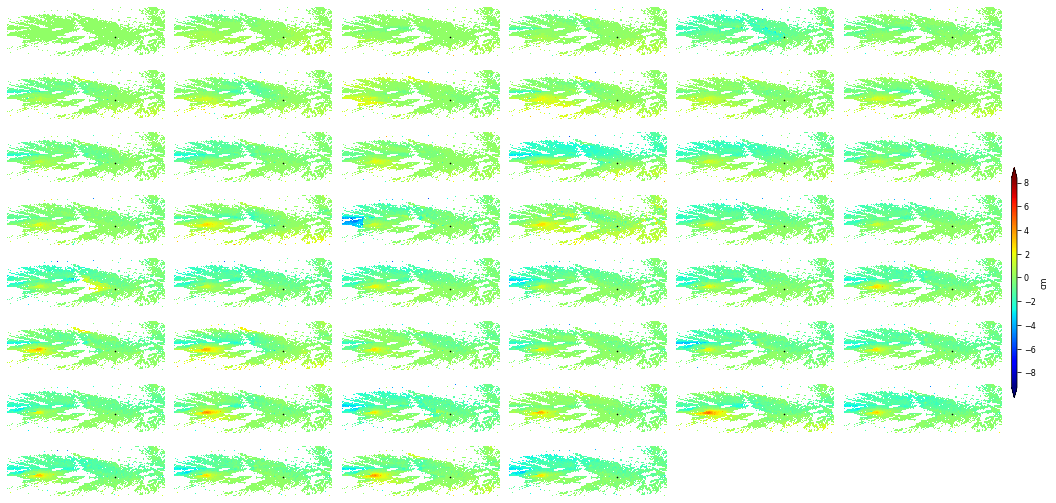

In [37]:
view.main('./miaplpy/network_single_reference/timeseries.h5 -u cm --notitle --notick --noaxis'.split())

### 2.9 Time series Corrections ###

This step would apply different timeseries corrections from MintPy. Since the outputs are in the same format as MintPy, you can switch on any of the correction methods. In fact you can use smallbaselineApp.py instead and run the steps after `correct_LOD`. 

Run `smallbaselineApp.py -h` for more help on the correction steps.

For this example we would only correct for topographic phase residuals and all others are set to `no` in the template file.

In [40]:
!miaplpyApp.py PichinchaSenDT142.txt --dostep timeseries_correction --dir ./miaplpy

--------------------------------------------------
MiaplPy version V0.2.0-47, date 2022-05-11
--RUN-at-2022-05-11 23:07:53.407493--
Current directory: /Users/Sara/data/test/PichinchaSenDT142
Run routine processing with arg_parser.py on steps: ['timeseries_correction']
Remaining steps: []
Project name: PichinchaSenDT142
--------------------------------------------------
20220511:230753 * miaplpyApp.py PichinchaSenDT142.txt --dostep timeseries_correction --dir ./miaplpy
Project name: PichinchaSenDT142
Go to work directory: /Users/Sara/data/test/PichinchaSenDT142/miaplpy
copy default template file /Users/Sara/soft/development/rsmas_insar/sources/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /Users/Sara/data/test/PichinchaSenDT142/PichinchaSenDT142.txt
update default template based on input custom template
    mintpy.compute.cluster: auto --> local
    mintpy.compute.numWorker: auto --> 8
    mintpy.reference.lalo: auto --> -0.1786, -78.5933
    m

open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
open geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file
read mean bperp from timese

save figure to file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/rms_timeseriesResidual_ramp.pdf


******************** step - reference_date ********************

reference_date.py -t /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/smallbaselineApp.cfg /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries.h5 /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries_demErr.h5
read reference date from file: reference_date.txt
input reference date: 20160419
--------------------------------------------------
change reference date for file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries.h5
input refDate is the same as the existing REF_DATE.
Nothing to be done.
--------------------------------------------------
change reference date for file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries_demErr.h5
input refDa

write data in block [0, 530, 0, 1685] to file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_geometryRadar.h5
--------------------------------------------------
reading incidenceAngle     in block (0, 0, 1684, 529) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 2 segments ...
write data in block [0, 530, 0, 1685] to file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_geometryRadar.h5
--------------------------------------------------
reading latitude           in block (0, 0, 1684, 529) from geometryRadar.h5 ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 2 segments ...
write data in block [0, 530, 0, 1685] to file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_geometryRadar.h5
--------------------------------------------------
reading longitude          in block (0, 0, 1684, 529) from geometryRadar.h5 ...
nearest resamp

read mask from file: geo_maskTempCoh.h5
masking out pixels with zero value in file: None
colormap: jet
plotting data ...
figure size : [12.00, 15.67]
show reference point
writing /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity.png with dpi=600
writing /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity_cbar.png
writing /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity.kml
remove /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity.kml
remove /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity.png
remove /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity_cbar.png
merged all files to /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/geo/geo_velocity.kmz


******************** step - hdfeos5 ********************
save time-series to HDF-

view.py ./miaplpy/network_single_reference/temporalCoherence.h5 -c gray --notick --noaxis --noverbose


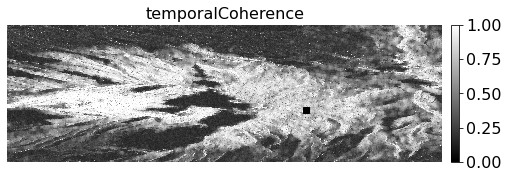

view.py ./miaplpy/network_single_reference/maskTempCoh.h5 -c gray --notick --noaxis --noverbose


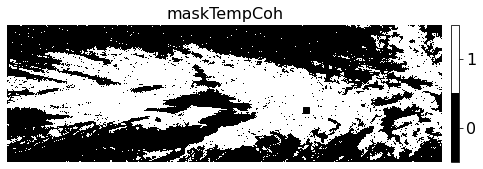

In [41]:
view.main('./miaplpy/network_single_reference/temporalCoherence.h5 -c gray --notick --noaxis --noverbose'.split())
view.main('./miaplpy/network_single_reference/maskTempCoh.h5 -c gray --notick --noaxis --noverbose'.split())

run view.py in MintPy version v1.3.3, date 2022-04-14
input file is timeseries file: /Users/Sara/data/test/PichinchaSenDT142/miaplpy/network_single_reference/timeseries_demErr.h5 in float32 format
file size in y/x: (530, 1685)
num of datasets in file timeseries_demErr.h5: 46
datasets to exclude (0):
[]
datasets to display (46):
['timeseries-20160419', 'timeseries-20160501', 'timeseries-20160513', 'timeseries-20160525', 'timeseries-20160606', 'timeseries-20160630', 'timeseries-20160724', 'timeseries-20160805', 'timeseries-20160817', 'timeseries-20160829', 'timeseries-20160910', 'timeseries-20160922', 'timeseries-20161016', 'timeseries-20161022', 'timeseries-20161109', 'timeseries-20161115', 'timeseries-20161209', 'timeseries-20170102', 'timeseries-20170126', 'timeseries-20170219', 'timeseries-20170303', 'timeseries-20170315', 'timeseries-20170327', 'timeseries-20170408', 'timeseries-20170420', 'timeseries-20170502', 'timeseries-20170514', 'timeseries-20170526', 'timeseries-20170607', 't

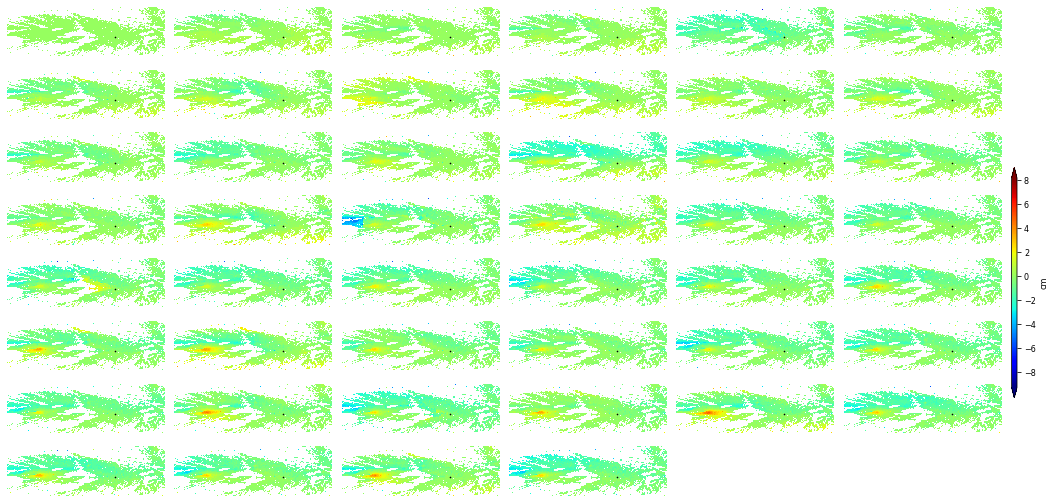

In [42]:
view.main('./miaplpy/network_single_reference/timeseries_demErr.h5 --notitle --notick --noaxis'.split())

***View with PS mask:***

view.py ./miaplpy/network_single_reference/velocity.h5 velocity -m ./miaplpy/maskPS.h5 --notick --noaxis --noverbose


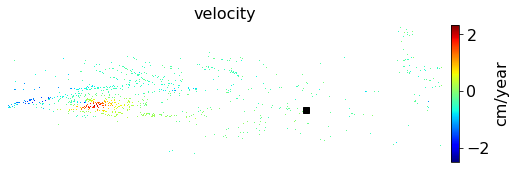

In [44]:
view.main('./miaplpy/network_single_reference/velocity.h5 velocity -m ./miaplpy/maskPS.h5 --notick --noaxis --noverbose'.split())


***View PS and DS:***

view.py ./miaplpy/network_single_reference/velocity.h5 velocity -m ./miaplpy/network_single_reference/maskTempCoh.h5 --notick --noaxis --noverbose


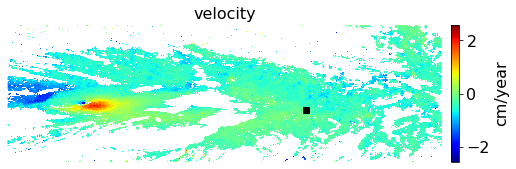

In [45]:
view.main('./miaplpy/network_single_reference/velocity.h5 velocity -m ./miaplpy/network_single_reference/maskTempCoh.h5 --notick --noaxis --noverbose'.split())

In [46]:
!ls -l ./miaplpy/network_single_reference/geo

total 410736
-rw-rw-r--  1 Sara  staff    3706376 May 11 23:09 geo_avgSpatialCoh.h5
-rw-rw-r--  1 Sara  staff    9438764 May 11 23:09 geo_geometryRadar.h5
-rw-rw-r--  1 Sara  staff     931264 May 11 23:09 geo_maskTempCoh.h5
-rw-rw-r--  1 Sara  staff    3707472 May 11 23:09 geo_temporalCoherence.h5
-rw-rw-r--  1 Sara  staff  176533824 May 11 23:09 geo_timeseries_demErr.h5
-rw-rw-r--  1 Sara  staff    7392248 May 11 23:09 geo_velocity.h5


view.py ./miaplpy/network_single_reference/geo/geo_velocity.h5 velocity --dem ./miaplpy/network_single_reference/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose


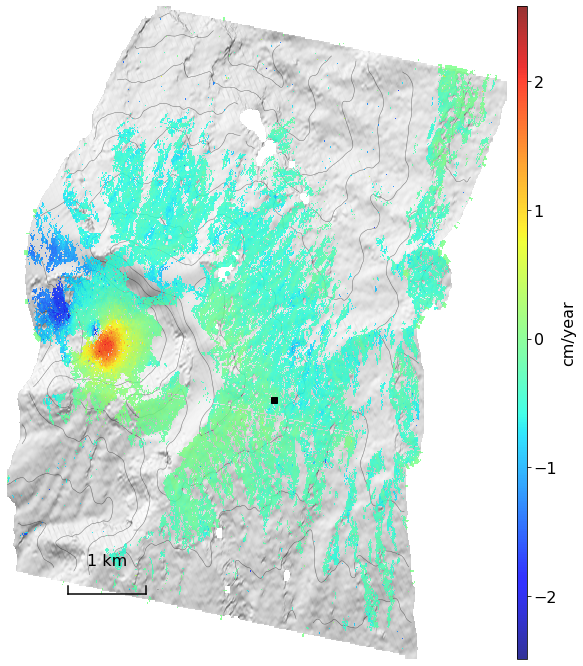

In [47]:
view.main('./miaplpy/network_single_reference/geo/geo_velocity.h5 velocity --dem ./miaplpy/network_single_reference/geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose'.split())


## 3. Correct for geolocation ##

Working in full resolution, required preceise geolocation specially in urban areas. 
This is a separate post processing step you may want to perform.

After topographic residual correction step of MintPy, There is `demErr.h5` as a by-product. You can use it as bellow to correct the geo coordinates stored in `./miaplpy/network_single_reference/inputs/geometryRadar.h5`. 

```
correct_geolocation.py -g ./miaplpy/network_single_reference/inputs/geometryRadar.h5 -d ./miaplpy/network_single_reference/demErr.h5
```

**Remember: This correction is in radar coordinate and you need to run it before geocode step in MintPy, or run the geocoding again:**

```
smallbaselineApp.py PichinchaSenDT142.txt --dir ./miaplpy --start geocode
```